In [826]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [827]:
# Read data and split columns
df = pd.read_table('auto-mpg.data', header=None) 
df.columns = ['one','car name']
df[['mpg','cylinders','displacement','horsepower',
    'weight','acceleration','model year','origin']] = df['one'].str.split(expand=True)
df = df.drop('one', axis=1)
df['weight'] = df['weight'].astype(str) + '0'
df.head()

,car name,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,buick skylark 320,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,plymouth satellite,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,amc rebel sst,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,ford torino,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [828]:
# Clean data and encode discrete values
df = df[df['horsepower'] != '?'] # Drop na values
unique_cars = df['car name'].unique()
unique_years = df['model year'].unique()
unique_cylinders = df['cylinders'].unique()
df['car name'] = df['car name'].map(dict(zip(sorted(unique_cars), range(len(unique_cars)))))
df['model year'] = df['model year'].map(dict(zip(sorted(unique_years), range(len(unique_years)))))
df['cylinders'] = df['cylinders'].map(dict(zip(sorted(unique_cylinders), range(len(unique_cylinders)))))
df = df.astype(float)
df.head()

,car name,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,48.0,18.0,4.0,307.0,130.0,3504.0,12.0,0.0,1.0
1,35.0,15.0,4.0,350.0,165.0,3693.0,11.5,0.0,1.0
2,229.0,18.0,4.0,318.0,150.0,3436.0,11.0,0.0,1.0
3,13.0,16.0,4.0,304.0,150.0,3433.0,12.0,0.0,1.0
4,159.0,17.0,4.0,302.0,140.0,3449.0,10.5,0.0,1.0


In [829]:
# Select sample for training
train_set = df.sample(frac=0.7)
test_set = df.drop(train_set.index)
Y = train_set['mpg'].values
X = train_set.drop('mpg', axis=1)
X['B_0'] = 1.0 # Append vector of 1's for Beta_0
X = X[['B_0', 'car name', 'cylinders', 'displacement', 'horsepower', 
       'weight', 'acceleration', 'model year', 'origin']].values

In [830]:
# Fit train set and obtain Beta coefficients
XTX = np.dot(X.transpose(), X) # X^T*X
XTY = np.dot(X.transpose(), Y) # X^T*Y
Beta = np.dot(np.linalg.inv(XTX), XTY) # Beta = ((X^T*X)^-1)(X^T*Y)
print('Beta = {}'.format(Beta))
B_0 = Beta[0] 
Beta = Beta[1:]

Beta = [ 3.24234899e+01 -5.70977546e-04 -2.07650069e+00  6.05853312e-03
 -7.70379837e-02 -1.80317020e-04 -2.25046356e-01  6.63416118e-01
  1.65682461e+00]


In [831]:
# Predict test data
actual = test_set['mpg']
predict_df = test_set.drop('mpg', axis=1)
predict_df['predicted'] = predict_df.apply(lambda x: B_0 + np.dot(Beta.transpose(), x.values), axis=1)
predict_df['actual'] = actual
predict_df['diff'] = predict_df['predicted'] - predict_df['actual']
predict_df['pct_diff'] = predict_df['diff'] / predict_df['actual']
exact = len(predict_df.loc[abs(predict_df['pct_diff']) <= 0.01])
under = len(predict_df.loc[predict_df['pct_diff'] < -0.01])
over = len(predict_df.loc[predict_df['pct_diff'] > 0.01])
SSE = (predict_df['diff']**2).sum()
SST = ((test_set['mpg'] - test_set['mpg'].mean())**2).sum()
SSR = SST - SSE # Compute residual sum of squares 
print('Residual statistics:')
print(predict_df['diff'].describe())
print('\nR^2 =', round(SSR/SST, 2)) # R^2 = SSR / SST
print('Number exact (Within 1%): {}, {}%'.format(exact, round(100*exact/len(test_set), 2)))
print('Number underestimated: {}, {}%'.format(under, round(100*under/len(test_set), 2)))
print('Number overestimated: {}, {}%'.format(over, round(100*over/len(test_set), 2)))

Residual statistics:
count    118.000000
mean      -0.133542
std        3.461618
min      -11.886462
25%       -2.382442
50%        0.231172
75%        2.369921
max        6.951330
Name: diff, dtype: float64

R^2 = 0.8
Number exact (Within 1%): 10, 8.47%
Number underestimated: 49, 41.53%
Number overestimated: 59, 50.0%


In [832]:
print('Percent difference statistics:')
print(predict_df['pct_diff'].describe())

Percent difference statistics:
count    118.000000
mean       0.015123
std        0.137623
min       -0.273851
25%       -0.080144
50%        0.011876
75%        0.113596
max        0.365859
Name: pct_diff, dtype: float64


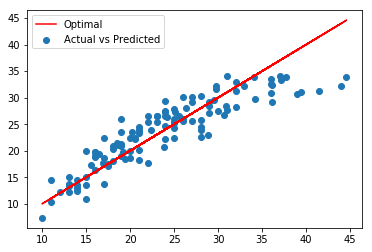

In [833]:
# Plot predictions versus actual values. Ideally would like to see points clustered around y = x
plt.scatter(predict_df['actual'], predict_df['predicted'], label='Actual vs Predicted')
plt.plot(predict_df['actual'], predict_df['actual'], label='Optimal', color='red')
plt.legend()